# Exploring Clustering Results
The file containing the clustering results is stored in the processed data folder with the suffix clean. The index is set to the first __Product group key__.

As a reminder the file is organized in three columns: _Product Group Key_, _Cluster Number_ and the corresponding _Centroid_ of the cluster.

In [1]:
import pandas as pd
import math
import numpy as np

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import copy as cp

import seaborn as sns

import statsmodels.api as sm


from IPython.display import display

processed_path = "..\\data\\processed\\"
interim_path = "..\\data\\interim\\"
file_name = "p2c1_clustering_clean.csv"
file_name = "p2c1_clustering_clean_jour.csv"

df_prd_cluster = pd.read_csv(interim_path+file_name, sep=';', encoding='utf-8').drop('Unnamed: 0',axis=1).set_index('Product Group key')

df_prd_cluster.head()


C:\Users\rahmim00\AppData\Local\Continuum\anaconda3\envs\dev_py34\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


,Cluster,Centroid
Product Group key,,
GBA001BND060FS,8,GWJ012NEU300FS
GBA001BND060SS,10,GWJ012SLX080FS
GBA001BND160FS,7,GCO003CQT080FS
GBA001BNR250FS,6,GKS001DCO500FS
GBA001CAR125FS,7,GCO003CQT080FS


## Get Products description
In order to get the product features description, an inner join on the product group key is operated on the cluster result with the products description file.

Since the clustering was calculated on the second level group, some columns of the description file must be dropped in order to avoid duplicates of the first level products (mainly Promo and Standard version of the products)

In [2]:
raw_path = "..\\data\\raw\\"
file_name = "bnd_products_desc.csv"

non_unique_features=["Key","Description","Unit of Measure 2 Ratio","Unit of Measure 4 Ratio","CONFEZIONE",\
                           "CONFEZIONE (Description)","IMBALLO","STD/PROMO","IMBALLO (Description)","STD/PROMO (Description)",\
                          "TIPO ARTICOLO","TIPO ARTICOLO (Description)"]

code_features = ["FAM DETTAGLIATA","FAM AGGREGATA","MARCHIO","GRUPPO MARCHIO","PACKAGING","SOTTO-TECNO",\
                           "PRODOTTO","CANALE DISTRIB","CLASSE COGE","FAM MARKETING","BIOLOGICO","GRUPPO MARCA COGE"]

df_produit = pd.read_csv(raw_path+file_name, sep=';', encoding='iso8859_2')\
                    .drop(non_unique_features,axis=1)\
                    .drop(code_features,axis=1)\
                    .drop_duplicates()\
                    .dropna()

#Join with clusters
product_cluster = df_produit.join(df_prd_cluster,on='Product Group key',how='inner')
print(product_cluster.shape)
product_cluster.head()

(316, 20)


,Product Group key,Product Group key2,Product Group key3,Product Group key4,Product Group key5,Product Group key6,FAM DETTAGLIATA (Description),FAM AGGREGATA (Description),MARCHIO (Description),GRUPPO MARCHIO (Description),PACKAGING (Description),SOTTO-TECNO (Description),PRODOTTO (Description),CANALE DISTRIB (Description),CLASSE COGE (Description),FAM MARKETING (Description),BIOLOGICO (Description),GRUPPO MARCA COGE (Description),Cluster,Centroid
2,GLA006BND100FS,FRABNDASTELA,FRABNDASTE,FRABND,FRA01,FRA,LAITUE,ASTERIX,BONDUELLE,BONDUELLE,0100 N/A,SALADES,MINI LAITUE VERTE,ARTICLES GP,PFC+ Frais,M'AMA NON M'AMA,NO,BND,4,GWS074BND125FS
63,GBA001BND060FS,FRABNDBOUQBA,FRABNDBOUQ,FRABND,FRA01,FRA,MACHE 4G,BOUQUETS,BONDUELLE,BONDUELLE,0060 N/A,SALADES,MACHE,ARTICLES GP,PFC+ Frais,JEUNES POUSSES MONO,NO,BND,8,GWJ012NEU300FS
64,GBA001BND060SS,FRABNDBOUQBA,FRABNDBOUQ,FRABND,FRA01,FRA,MACHE 4G,BOUQUETS,BONDUELLE,BONDUELLE,0060 N/A,SALADES,MACHE,ARTICLES GP,PFC+ Frais,JEUNES POUSSES MONO,NO,BND,10,GWJ012SLX080FS
79,GBA001BND160FS,FRABNDBOUQBA,FRABNDBOUQ,FRABND,FRA01,FRA,MACHE 4G,BOUQUETS,BONDUELLE,BONDUELLE,0160 N/A,SALADES,MACHE,ARTICLES GP,PFC+ Frais,JEUNES POUSSES MONO,NO,BND,7,GCO003CQT080FS
91,GBA005BND080FS,FRABNDBOUQBA,FRABNDBOUQ,FRABND,FRA01,FRA,MACHE 4G,BOUQUETS,BONDUELLE,BONDUELLE,0080 N/A,SALADES,MACHE 24H,ARTICLES GP,PFC+ Frais,JEUNES POUSSES CONTADINO,NO,BND,4,GWS074BND125FS


Save the final result into a csv file for further exploration

In [3]:
filename = 'bnd_product_cluster_clean.csv'
file_name = "p2c1_clustering_clean_jour.csv"
product_cluster.to_csv(processed_path+filename,sep=';',encoding='iso8859_2')

# Homogeneity Test
In order to detect specific caraterstics for each resulted cluster we perform a statistic test based on Pearsons chi-square score with the hypothesis of a uniform distribution.

Features with the pvalues lower than 0.1 are displayed for analysis

## Calculate modalities frequency through clusters
As a first step, all the distrubtions of modalities across features and clusters are calculated and stored in one array structered as follows:

One array for each cluster which contains a dictionnary of features. Each feature is again a dictionary of modalities and their occurence in that cluster

In [4]:
#get the features
features = product_cluster.columns[:-2]

#get the clusters (actually its a range(1,nb_cluster))
clusters = set(product_cluster['Cluster'].values)

#array to store each cluster and freq for all the features
clusters_feature_dist = [0] #to shift the indices to clusters

#loop trhough features
for c in clusters:
    feature_dist = dict()
    for feature in features:
        freq = product_cluster[product_cluster['Cluster']==c].groupby(feature)[feature].count()
        feature_dist[feature]=freq.to_dict()
    clusters_feature_dist.append(feature_dist)


## Chi-square test over clusters

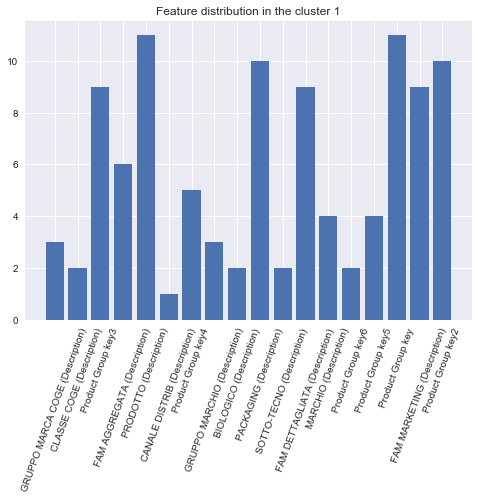

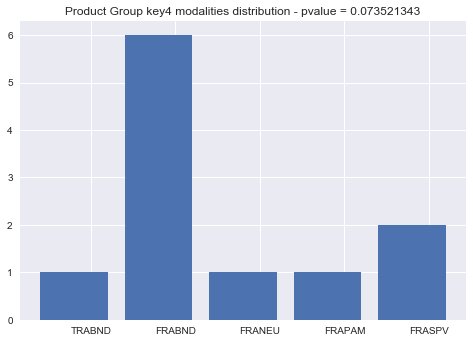

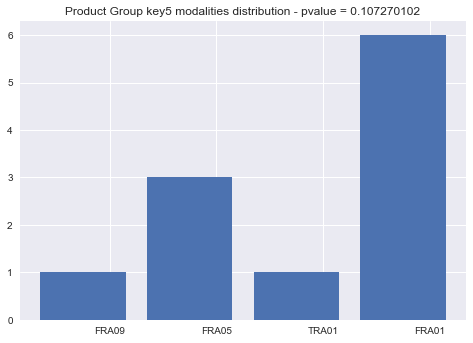

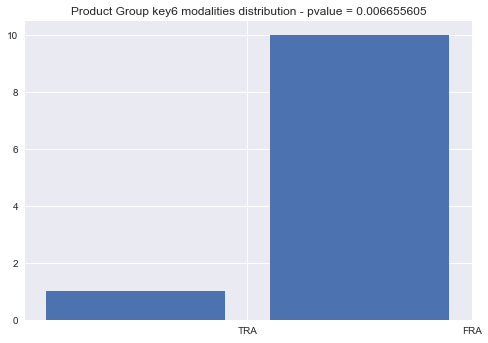

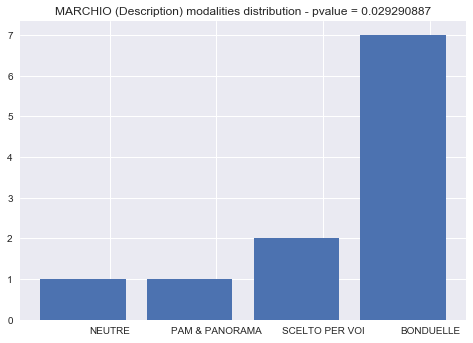

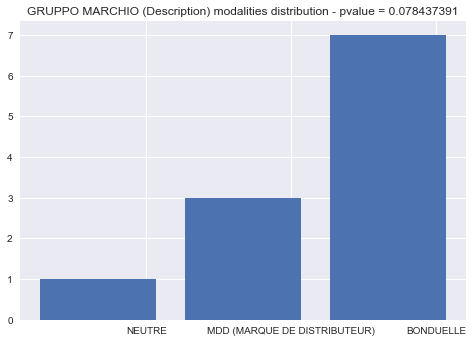

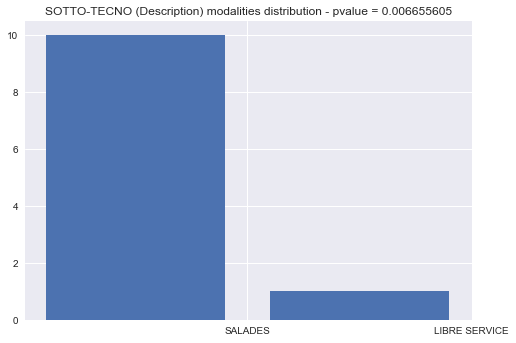

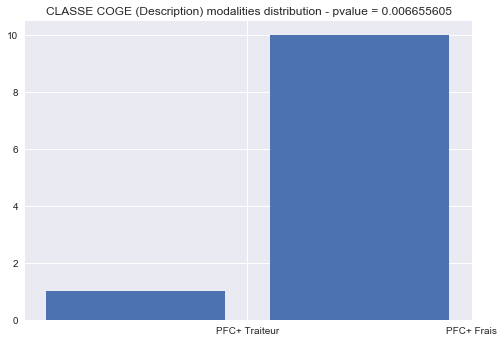

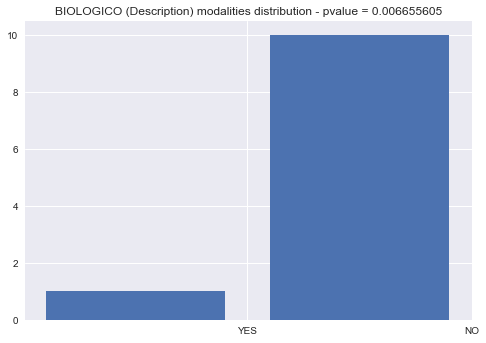

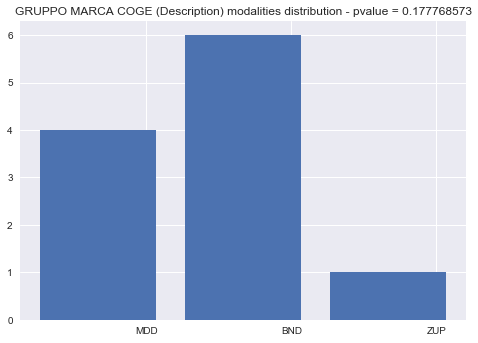

In [5]:
from scipy.stats import chisquare

pthreashold = 0.2

#get the features
features = product_cluster.columns[:-2]
clusters = [1]

res_features_over_cluster = [0]

for c in clusters:
    #align each feature with its distrubtion in this cluster c
    cluster_feature_dist = clusters_feature_dist[c]
    dist = [len(x) for x in list(cluster_feature_dist.values())]
    keys = list(cluster_feature_dist.keys())    

    #plot the dist of number of elements by feature in this clust
    plt.title("Feature distribution in the cluster %d"%c)
    plt.bar(range(len(keys)),dist)
    plt.xticks(range(len(keys)),keys,rotation=70)
    
    #for each feature display its distribution over modalities
    for feature in features:
        #get information from the previous array
        cluster_feature_dist = clusters_feature_dist[c]
        feature_distribution = list(cluster_feature_dist[feature].values())
        feature_keys = list(cluster_feature_dist[feature].keys())
        nftrs = len(feature_keys)
        chisq, p = chisquare(feature_distribution)
        if p<pthreashold:
            plt.figure()
            plt.title("%s modalities distribution - pvalue = %.9f"%(feature,p))
            plt.bar(np.arange(nftrs),feature_distribution)
            plt.xticks(np.arange(nftrs)+(1.0/nftrs),feature_keys,rotation=70 if nftrs>5 else 0)
    plt.show(block = True)
    


## Calculate modalities frequency through features

In [6]:
#get the features
features = product_cluster.columns[0:-2]

#get the clusters (actually its a range(1,nb_cluster))
clusters = set(product_cluster['Cluster'].values)

#dict to store each feater and freq for all the clusters
features_clust_dist = dict()

#invert the dict and get it by feature 
for f in features:
    freq = dict()
    for c in clusters: 
        freq[c] =  clusters_feature_dist[c][f]
    features_clust_dist[f] = freq

## Chi-square test over features

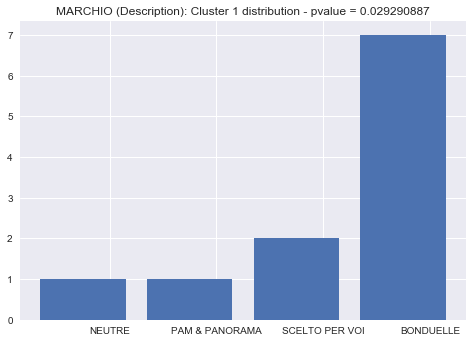

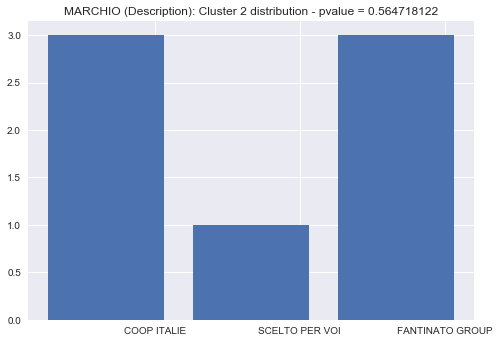

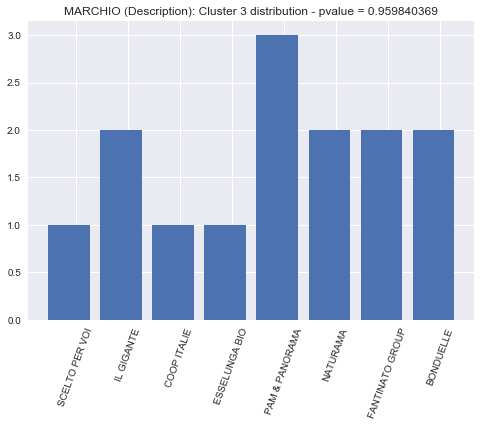

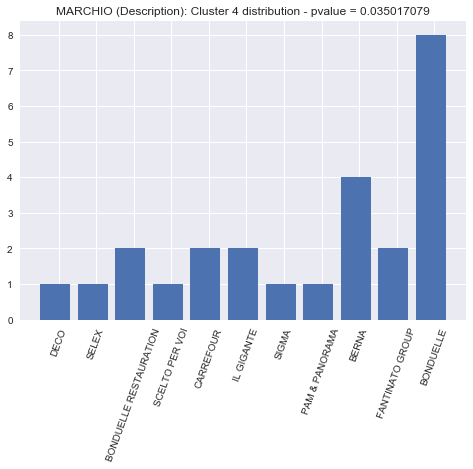

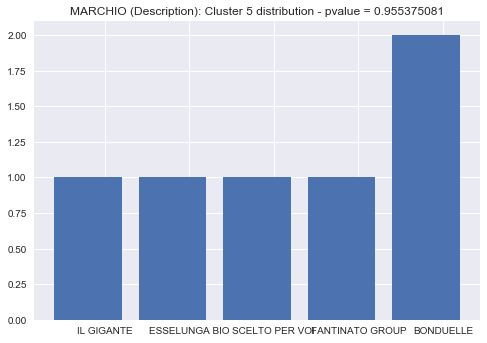

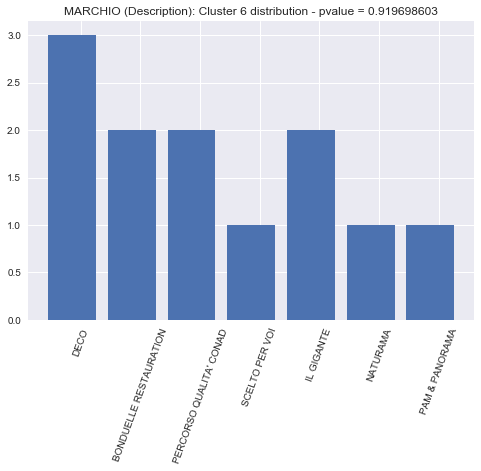

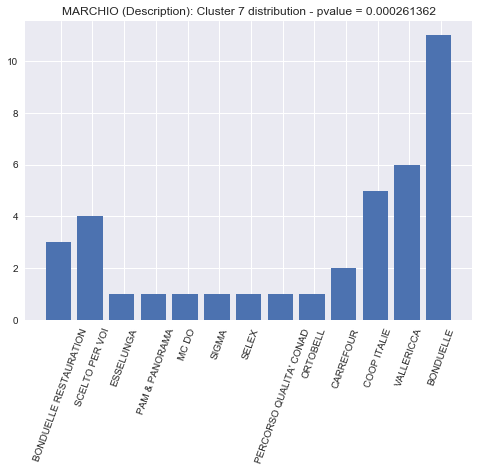

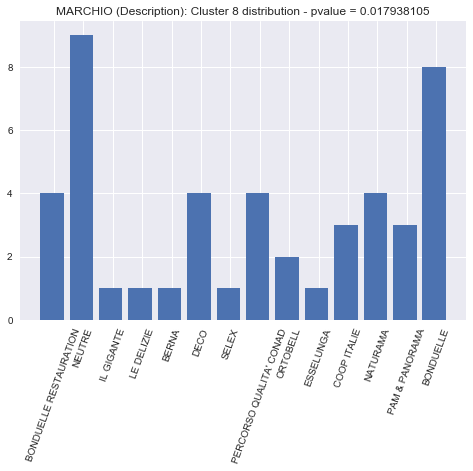

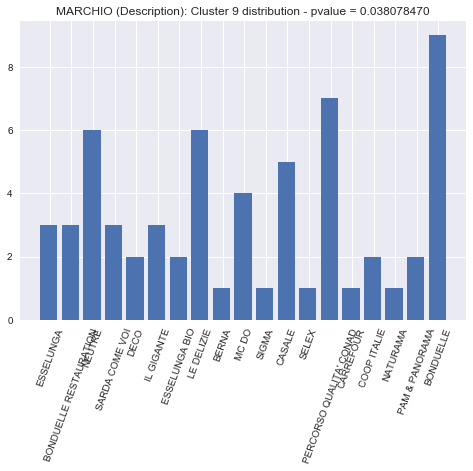

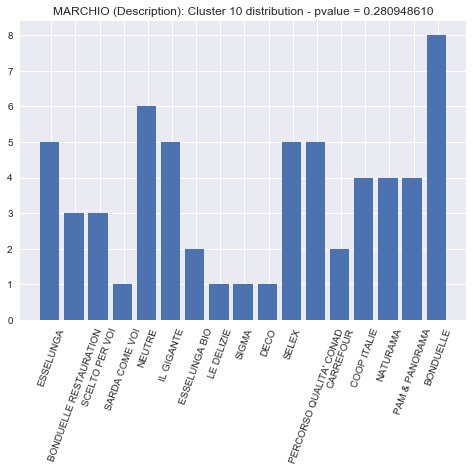

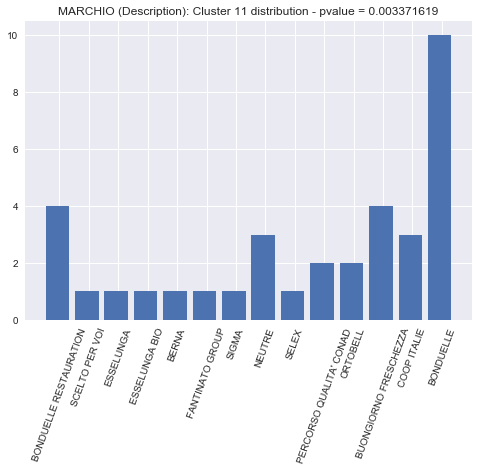

In [7]:
pthreashold = 1
clusters = set(product_cluster['Cluster'].values)

features = ["MARCHIO (Description)"]

for f in features:
    for c in clusters:
        #get information from the previous array
        feature_clust_dist = features_clust_dist[f]
        feature_distribution = list(feature_clust_dist[c].values())
        feature_keys = list(feature_clust_dist[c].keys())
        nftrs = len(feature_keys)
        chisq, p = chisquare(feature_distribution)
        if p<pthreashold:
            plt.figure()
            plt.title("%s: Cluster %d distribution - pvalue = %.9f"%(f,c,p))
            plt.bar(np.arange(nftrs),feature_distribution)
            plt.xticks(np.arange(nftrs)+(1.0/nftrs),feature_keys,rotation=70 if nftrs>5 else 0)
            
    plt.show(block = True)     



## Modalities distribution

In [8]:
clusters = set(product_cluster['Cluster'].values)
nclusters = len(clusters)
#get the features
features = product_cluster.columns[0:-2]

modalities_clust_dist = dict()

for f in features:
    feature_sum=[]
    modalities = set(product_cluster[f].values)
    modalities_distribution=dict()
    for m in modalities:
        modality_distribution = np.zeros((nclusters+1))
        for c in clusters:
            #get information from the previous array
            feature_clust_dist = features_clust_dist[f]
            modality_distribution[c] +=(feature_clust_dist[c][m] if m in feature_clust_dist[c] else 0)
        modalities_distribution[m] = modality_distribution    
    modalities_clust_dist[f] = modalities_distribution 

## Chi-square test for modalities over clusters

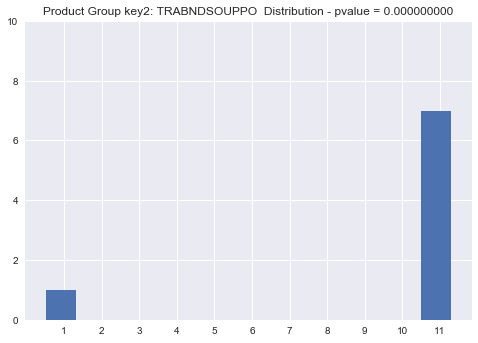

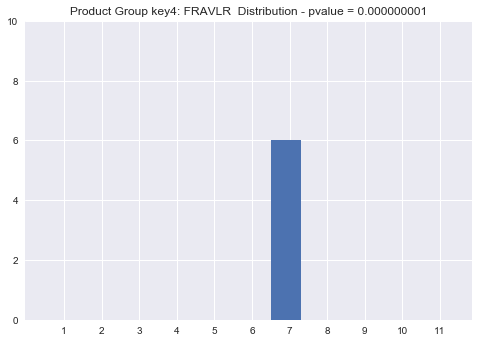

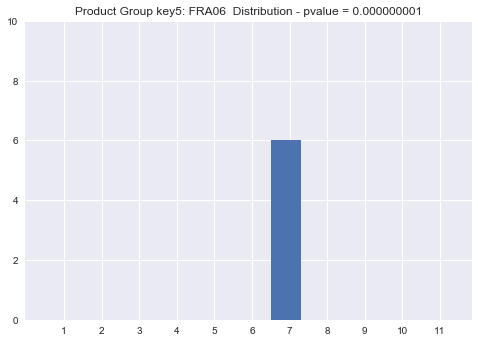

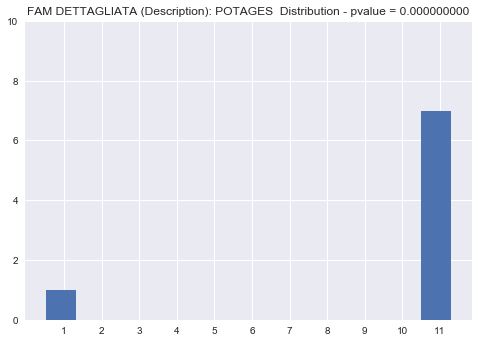

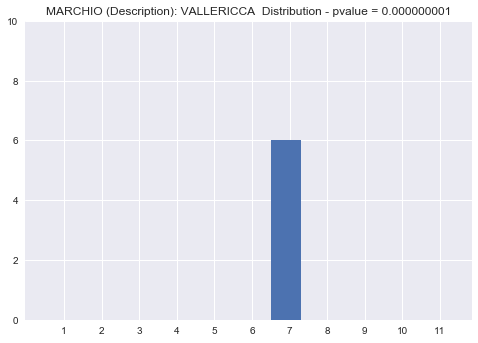

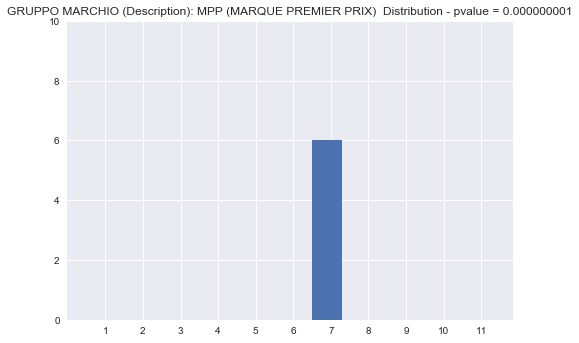

In [9]:
clusters = set(product_cluster['Cluster'].values)
nclusters = len(clusters)

features = product_cluster.columns[0:-2]
pthreashold = 0.2

n_min_dist = 2
min_members = 5


min_dust  = True



for f in features:
    modalities = set(product_cluster[f].values)
    r = len(modalities)
    for m in modalities:
        modality_dist = modalities_clust_dist[f][m]
        md = np.count_nonzero(modality_dist)<=n_min_dist and np.max(modality_dist)>min_members
        chisq, p = chisquare(modality_dist)
        if p<pthreashold and (md and min_dust):
            plt.figure()
            plt.title("%s: %s  Distribution - pvalue = %.9f"%(f,m,p))
            plt.bar(np.arange(nclusters)+1,modality_dist[1:])
            plt.xticks(np.arange(nclusters)+(1.0/nclusters)+1,np.arange(nclusters)+1)
            if np.max(modality_dist[1:])<10: plt.ylim(0,10)
    plt.show(block = True)  

## MCA Analysis

### Remove unbalanced columns

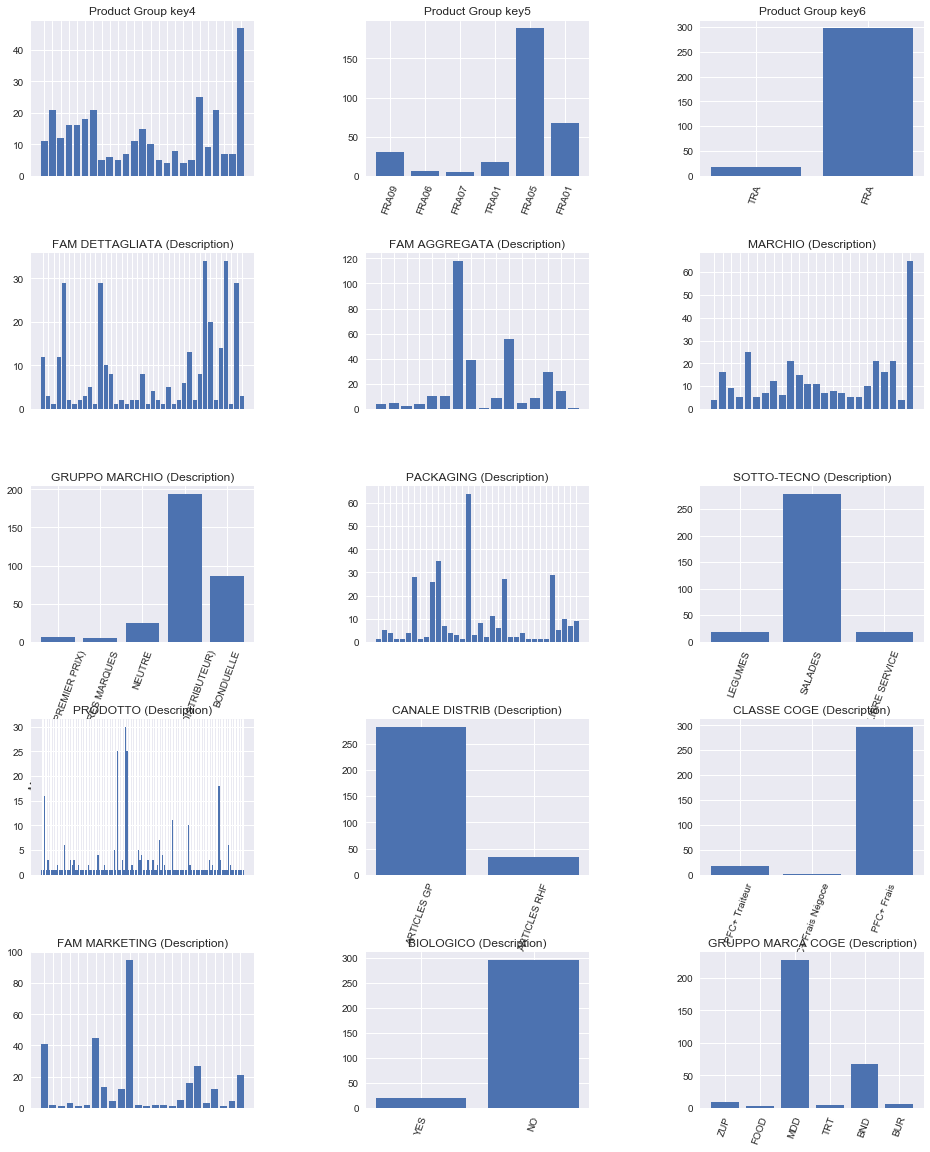

In [10]:
features_df = product_cluster.iloc[:,3:-2]
plt.figure(figsize=(16,20))
features = features_df.columns
for i,f in enumerate(features):
    counts = features_df.groupby([f])[f].count().to_dict()
    dist = list(counts.values())
    keys = list(counts.keys())
    chisq, p = chisquare(dist)
    plt.subplot(5,3,i+1)
    plt.title("%s"%(f))
    plt.bar(range(len(keys)),dist)
    plt.xticks(range(len(keys)),keys,rotation=70)
    if len(keys)>10: plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.subplots_adjust(wspace=0.5, hspace=0.5)      
plt.show()

### Apply MCA

C:\Users\rahmim00\AppData\Local\Continuum\anaconda3\envs\dev_py34\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


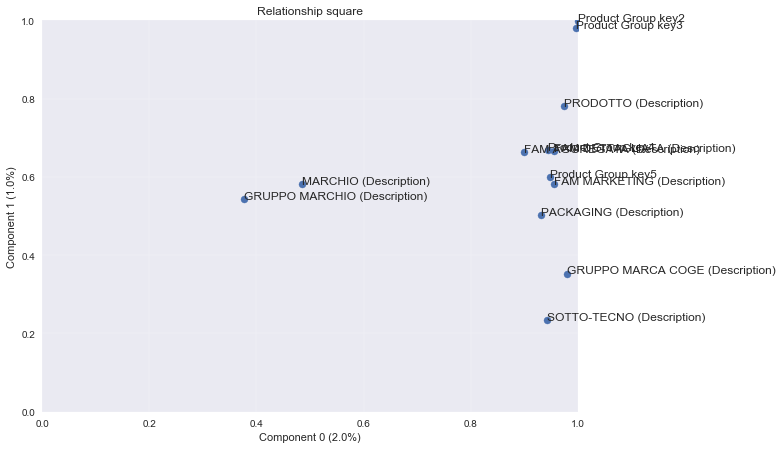

In [15]:
import prince

unbalanced = ["Product Group key6","CANALE DISTRIB (Description)","CLASSE COGE (Description)","BIOLOGICO (Description)"]


features_df = product_cluster.iloc[:,1:-2].drop(unbalanced,axis=1)
mca = prince.MCA(features_df)
mca.plot_relationship_square()
plt.show()